In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.layers import Flatten, Concatenate, Dropout, Reshape, BatchNormalization
from keras.models import Model
workdir = "C://Users//a//Desktop//Ronny_TF//Ronny_Deep_vs_CDRscan//method_comparison_w_ccle_exp_or_mut_data//dataset//ccle_exp_mut_dataset"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16431969587262265314
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9234234737
locality {
  bus_id: 1
}
incarnation: 2711665130555425465
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
dataset = np.load(workdir + "//190507_ccle_cell_gdsc_mut_drug_vali_for_aron.npz")
ss0 = np.load(workdir + '//190507_shuffle_split_ccle_cell_gdsc_mut_r0_9_1.npz')

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,200):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

1 2


In [8]:
x.shape

(8727, 21213)

In [9]:
training_image_array.shape

(7855, 21213)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
shape_value = train_X.shape[1]
print(shape_value)

21213


In [13]:
train_X_cell = train_X[:,:shape_value]
train_X_drug =train_X[:,shape_value:]
test_X_cell = test_X[:,:shape_value]
test_X_drug = test_X[:,shape_value:]

In [14]:
train_X_cell.shape

(7855, 21213)

In [15]:
train_X_cell = train_X_cell.reshape(train_X_cell.shape[0], train_X_cell.shape[1], 1)
train_X_drug = train_X_drug.reshape(train_X_drug.shape[0], train_X_drug.shape[1], 1)
test_X_cell = test_X_cell.reshape(test_X_cell.shape[0], test_X_cell.shape[1], 1)
test_X_drug = test_X_drug.reshape(test_X_drug.shape[0], test_X_drug.shape[1], 1)
#input_shape = (img_rows, img_cols, 1)

In [16]:
print(train_X_cell.shape,train_X_drug.shape, train_y.shape, test_X_cell.shape,test_X_drug.shape, test_y.shape)

(7855, 21213, 1) (7855, 0, 1) (7855,) (872, 21213, 1) (872, 0, 1) (872,)


In [17]:
train_X_cell.shape

(7855, 21213, 1)

In [18]:
train_X_cell = train_X_cell.astype('float32')
test_X_cell = test_X_cell.astype('float32')
train_X_drug = train_X_drug.astype('float32')
test_X_drug = test_X_drug.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (7855, 21213)
7855 train samples
872 test samples


In [19]:
with K.tf.device('/GPU:0'):
    input_cell = Input(shape=(train_X_cell.shape[1], train_X_cell.shape[2]), name='cell_input')
#     input_drug = Input(shape=(train_X_drug.shape[1], train_X_drug.shape[2]), name='drug_input')

    conv_cell_line_1 = Conv1D(filters=50, kernel_size=700, strides=5, activation='tanh')(input_cell)
    maxpool_cell_line_1 = MaxPooling1D(pool_size=5)(conv_cell_line_1)
    conv_cell_line_2 = Conv1D(filters=30, kernel_size=5, strides=2, activation='relu')(maxpool_cell_line_1)
    maxpool_cell_line_2 = MaxPooling1D(pool_size=10)(conv_cell_line_2)
    flatten_cell_line = Flatten()(maxpool_cell_line_2)
    dense_cell_line = Dense(100, activation='relu')(flatten_cell_line)
    dropout_cell_line = Dropout(0.1)(dense_cell_line)

#     conv_drug_1 = Conv1D(filters=50, kernel_size=200, strides=3, activation='tanh')(input_drug)
#     maxpool_drug_1 = MaxPooling1D(pool_size=5)(conv_drug_1)
#     conv_drug_2 = Conv1D(filters=30, kernel_size=50, strides=5, activation='relu')(maxpool_drug_1)
#     maxpool_drug_2 = MaxPooling1D(pool_size=10)(conv_drug_2)
#     flatten_drug = Flatten()(maxpool_drug_2)
#     dense_drug = Dense(100, activation='relu')(flatten_drug)
#     dropout_drug = Dropout(0.1)(dense_drug)

#     concatenate = Concatenate()([dropout_cell_line, dropout_drug])
    dense_1 = Dense(300, activation='tanh')(dropout_cell_line)
    dropout_1 = Dropout(0.1)(dense_1)
    reshape_1 = Reshape((300,1))(dropout_1)
    conv_1 = Conv1D(filters=30, kernel_size=150, strides=1, activation='relu')(reshape_1)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)
    conv_3 = Conv1D(filters=5, kernel_size=5, strides=1, activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling1D(pool_size=3)(conv_3)
    dropout_2 = Dropout(0.1)(maxpool_3)
    flatten = Flatten()(dropout_2)
    dropout_3 = Dropout(0.2)(flatten)
    output = Dense(1, activation='linear', name='pred_lnIC50')(dropout_3)
    model = Model(inputs=[input_cell], outputs=output, name='MasterModel')


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cell_input (InputLayer)      (None, 21213, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4103, 50)          35050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 820, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 408, 30)           7530      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               120100    
__________

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [22]:
optim = Adam(lr=0.0002)

model.compile(loss='mse',
		      optimizer=optim,
			  metrics=['mse','mae'])

StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit(train_X_cell, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X_cell, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2019-05-16 15:03:10.104937
Train on 7855 samples, validate on 872 samples
Epoch 1/150
7855/7855 [==============================] - 4s 541us/step - loss: 4.2847 - mean_squared_error: 4.2847 - mean_absolute_error: 1.7282 - val_loss: 3.7296 - val_mean_squared_error: 3.7296 - val_mean_absolute_error: 1.5505
Epoch 2/150
7855/7855 [==============================] - 3s 360us/step - loss: 4.0490 - mean_squared_error: 4.0490 - mean_absolute_error: 1.5820 - val_loss: 3.7398 - val_mean_squared_error: 3.7398 - val_mean_absolute_error: 1.5527
Epoch 3/150
7855/7855 [==============================] - 3s 355us/step - loss: 4.0434 - mean_squared_error: 4.0434 - mean_absolute_error: 1.5848 - val_loss: 3.8017 - val_mean_squared_error: 3.8017 - val_mean_absolute_error: 1.6130
Epoch 4/150
7855/7855 [==============================] - 3s 361us/step - loss: 4.0549 - mean_squared_error: 4.0549 - mean_absolute_error: 1.5987 - val_loss: 3.7087 - val_mean_squared_error: 3.7087 - val_mean_absolute_erro

Epoch 69/150
7855/7855 [==============================] - 3s 360us/step - loss: 3.8337 - mean_squared_error: 3.8337 - mean_absolute_error: 1.5117 - val_loss: 3.8957 - val_mean_squared_error: 3.8957 - val_mean_absolute_error: 1.5221
Epoch 70/150
7855/7855 [==============================] - 3s 363us/step - loss: 3.8339 - mean_squared_error: 3.8339 - mean_absolute_error: 1.5009 - val_loss: 3.8875 - val_mean_squared_error: 3.8875 - val_mean_absolute_error: 1.5260
Epoch 71/150
7855/7855 [==============================] - 3s 367us/step - loss: 3.8259 - mean_squared_error: 3.8259 - mean_absolute_error: 1.5050 - val_loss: 3.8840 - val_mean_squared_error: 3.8840 - val_mean_absolute_error: 1.5294
Epoch 72/150
7855/7855 [==============================] - 3s 361us/step - loss: 3.8214 - mean_squared_error: 3.8214 - mean_absolute_error: 1.5016 - val_loss: 3.9209 - val_mean_squared_error: 3.9209 - val_mean_absolute_error: 1.5261
Epoch 73/150
7855/7855 [==============================] - 3s 369us/step 

7855/7855 [==============================] - 3s 364us/step - loss: 3.8036 - mean_squared_error: 3.8036 - mean_absolute_error: 1.4971 - val_loss: 3.9255 - val_mean_squared_error: 3.9255 - val_mean_absolute_error: 1.5350
Epoch 140/150
7855/7855 [==============================] - 3s 362us/step - loss: 3.8150 - mean_squared_error: 3.8150 - mean_absolute_error: 1.5024 - val_loss: 3.9553 - val_mean_squared_error: 3.9553 - val_mean_absolute_error: 1.4984
Epoch 141/150
7855/7855 [==============================] - 3s 360us/step - loss: 3.8106 - mean_squared_error: 3.8106 - mean_absolute_error: 1.5029 - val_loss: 3.9154 - val_mean_squared_error: 3.9154 - val_mean_absolute_error: 1.5256
Epoch 142/150
7855/7855 [==============================] - 3s 369us/step - loss: 3.8098 - mean_squared_error: 3.8098 - mean_absolute_error: 1.4892 - val_loss: 3.9097 - val_mean_squared_error: 3.9097 - val_mean_absolute_error: 1.5685
Epoch 143/150
7855/7855 [==============================] - 3s 359us/step - loss: 3

In [23]:
import json
from keras.models import model_from_json, load_model
workdir = "C://Users//a//Desktop//Ronny_TF//Ronny_Deep_vs_CDRscan//method_comparison_w_ccle_exp_or_mut_data//190516_CDRScan_master_mut_archi_w_mut_only"
# Option 1: Save Weights + Architecture
model.save_weights(workdir + '//model_fix_v3.h5')
with open(workdir + '//model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [24]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [25]:
test_eval = model.evaluate(test_X_cell, test_label_array, verbose=1)

872/872 [==============================] - 0s 249us/step


In [26]:
test_eval

[3.9343215653655728, 3.9343215653655728, 1.5207615576752829]

In [27]:
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [28]:
np.savetxt("ccle_mut_only_mse_cdrscan_master_150_100_2080ti_v3.csv", np_acc, delimiter=",")
np.savetxt("ccle_mut_only_val_mse_cdrscan_master_150_100_2080ti_v3.csv", np_val_acc, delimiter=",")
np.savetxt("ccle_mut_only_loss_cdrscan_master_150_100_2080ti_v3.csv", np_loss, delimiter=",")
np.savetxt("ccle_mut_only_val_loss_cdrscan_master_150_100_2080ti_v3.csv", np_val_loss, delimiter=",")

In [29]:
import matplotlib
from matplotlib import pyplot as plt

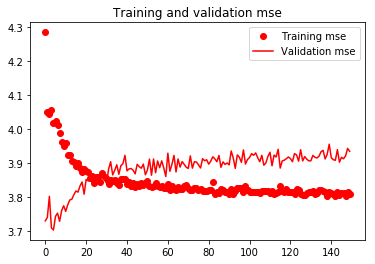

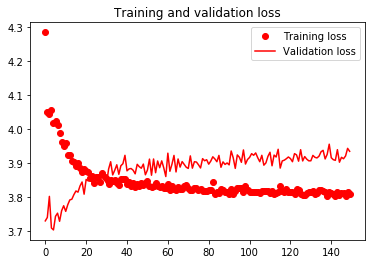

In [30]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse',c='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse',c='red')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',c='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
predicted_classes = model.predict(test_X_cell)

In [32]:
predicted_value = predicted_classes

In [33]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [34]:
c.to_csv(workdir + '//190516_CDRScan_master_mut_archi_w_mut_only_result.csv')

In [35]:
c

,Predicted,Test
0,1.054049,2.079442
1,1.253023,2.079442
2,1.253023,-3.956153
3,0.038038,2.079442
4,1.399332,-1.277287
5,0.576247,2.079442
6,1.305959,1.937675
7,0.838815,-0.531687
8,1.450228,-2.943258
9,-0.280263,0.768535


In [36]:
predicted_value.shape

(872, 1)

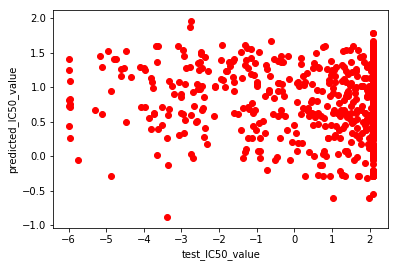

In [37]:
plt.scatter(test_label_array,predicted_value,c='red')
plt.xlabel('test_IC50_value')
plt.ylabel('predicted_IC50_value')
plt.savefig(workdir + '//190516_CDRScan_master_mut_archi_w_mut_only_test_scatterplot.png')

In [38]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 1.9835124633413586
